In [1]:
# Pytorch
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
# External
import BatchMaker
import numpy as np
import PIL
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
# Built-Ins
import math
import random
import time
import os
import glob
# Version control
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.5.0
Torchvision Version:  0.6.0


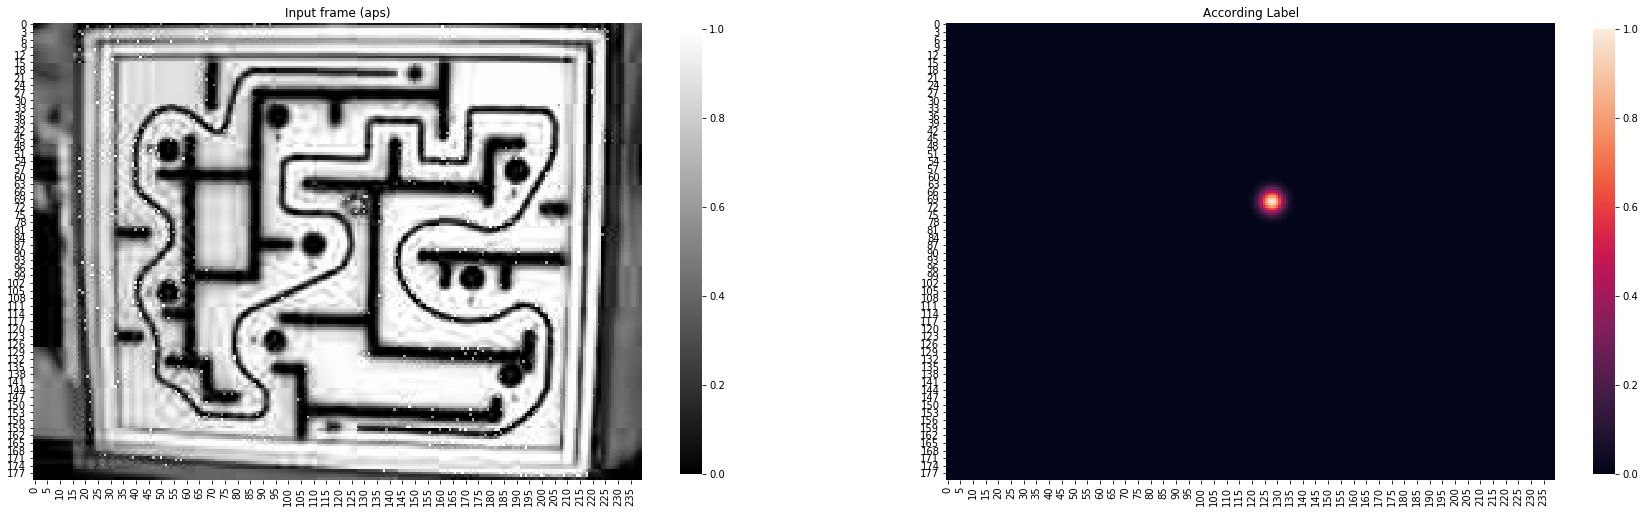

In [2]:
# Visualize the Data
fig = plt.figure(figsize = (30,30))
ax1 = fig.add_subplot(2, 2, 1)
ax1.set_title('Input frame (aps)')
ax2 = fig.add_subplot(2, 2, 2)
ax2.set_title('According Label')

x = Image.open('Data/frames/frame-0352.jpg')
y = Image.open('Data/labels/label-0352.png')

x = TF.to_tensor(x)
y = TF.to_tensor(y)

sns.heatmap(x[0], cmap='gray', ax=ax1, square=True, cbar_kws={'shrink': .6})
sns.heatmap(y[0], ax=ax2, square=True, cbar_kws={'shrink': .6})
plt.show()

In [3]:
batch_size = 1

training_file = "training.csv"
testing_file = "testing.csv"

Generator = BatchMaker.BatchMaker
train_inputs, train_labels = Generator(training_file)
test_inputs, test_labels = Generator(testing_file)

transform = transforms.Compose([
    transforms.ToPILImage(),
#     transforms.Resize((165, 220)),
    transforms.RandomRotation(degrees=45),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),

])

class CreateDataset(Dataset):
    def __init__(self, inputs, labels, transform=transform):
        self.inputs = torch.FloatTensor(inputs)
        self.labels = torch.FloatTensor(labels)
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.inputs[index]
        y = self.labels[index]
        
        seed = np.random.randint(2147483647) 
        random.seed(seed)
        
        x = self.transform(x)
        if random.random() > 0.5:
            x = TF.adjust_brightness(x, 0.7)
        
        if random.random() > 0.5:
            x = TF.adjust_contrast(x, 0.67)
            
        x = TF.to_tensor(x)
        random.seed(seed)
        y = self.transform(y)
        y = TF.to_tensor(y)

        return x, y

    def __len__(self):
        return len(self.inputs)

    
# Get the data, transform it
data = {
   'train':
   CreateDataset(train_inputs, train_labels),
#    'val':
#    CreateDataset(val_inputs, val_labels),
    'test':
   CreateDataset(test_inputs, test_labels)
}



# img_num = 0
# for img, label in data['test']:
#     print(img.shape)
#     save_image(data['test'][0][0], 'img'+str(img_num)+'.png')
#     img_num += 1
#     if img_num == 10:
#         break

# Load Data in batches, shuffled
dataloaders = {
   'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True, drop_last=True),
#    'val': DataLoader(data['val'], batch_size=batch_size, shuffle=True, drop_last=True),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True, drop_last=True),
}

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(64))
    
        self.layer2 = nn.Sequential( 
            nn.Conv2d(64, 64,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(64))
        
        self.layer3 = nn.Sequential(
            nn.MaxPool2d(2, stride=2, padding=0))
            
        self.layer4 = nn.Sequential(
            nn.Conv2d(64,128,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(128))

        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 128,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(128))
            
        self.layer6 = nn.Sequential(
            nn.MaxPool2d(2, stride=2, padding=0))
            
        self.layer7 = nn.Sequential(
            nn.Conv2d(128, 256,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(256))
            
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 256,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(256))
            
        self.layer9 = nn.Sequential(
            nn.Conv2d(256, 256,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(256))
            
        self.layer10 = nn.UpsamplingBilinear2d(scale_factor=2)
            
        self.layer11 = nn.Sequential(
            nn.Conv2d(256, 128,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(128))
            
        self.layer12 = nn.Sequential(
            nn.Conv2d(128, 128,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(128))
            
        self.layer13 = nn.Sequential(
            nn.Conv2d(128, 128,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(128))
            
        self.layer14 = nn.UpsamplingBilinear2d(scale_factor=2)
            
        self.layer15 = nn.Sequential(
            nn.Conv2d(128, 64,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(64))
            
        self.layer16 = nn.Sequential(
            nn.Conv2d(64, 64,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(64))
            
        self.layer17 = nn.Sequential(
            nn.Conv2d(64, 1,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(1))
        
        self.layer18 = nn.Softmax(dim=1)
            
            
    def forward(self,x):
        x = self.layer1(x)  
        x = self.layer2(x)  
        x = self.layer3(x)  
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)  
        x = self.layer7(x)
        x = self.layer8(x)
        x = self.layer9(x)  
        x = self.layer10(x)  
        x = self.layer11(x)  
        x = self.layer12(x)  
        x = self.layer13(x)  
        x = self.layer14(x)  
        x = self.layer15(x)  
        x = self.layer16(x)
        x = self.layer17(x) 
        x = x.view(1, -1)
        x = self.layer18(x)
        x = x.reshape(1, 180, 240)
        
        return x

In [5]:
# Check if GPU is available and move the model over to GPU
if torch.cuda.is_available():
    device = torch.device("cuda: 0")
    gpu_name = torch.cuda.get_device_name()
    print(f"Running on your {gpu_name} (GPU)")
else:
    device = torch.device("cpu")
    print("Running on your CPU")

net = CNN().to(device)

Running on your GeForce GTX 1080 (GPU)


In [6]:
# Define the Loss function: LAD-Loss + distance factor
def distance(output, target):
    center_output = np.where(output==np.amax(output))
    center_target = np.where(target==np.amax(target))
    
    x1 = center_output[1][0]
    y1 = center_output[0][0]
    x2 = center_target[1][0]
    y2 = center_target[0][0]

    distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return distance

loss_fn = nn.L1Loss(reduction='sum')

Epoch 1/1
----------


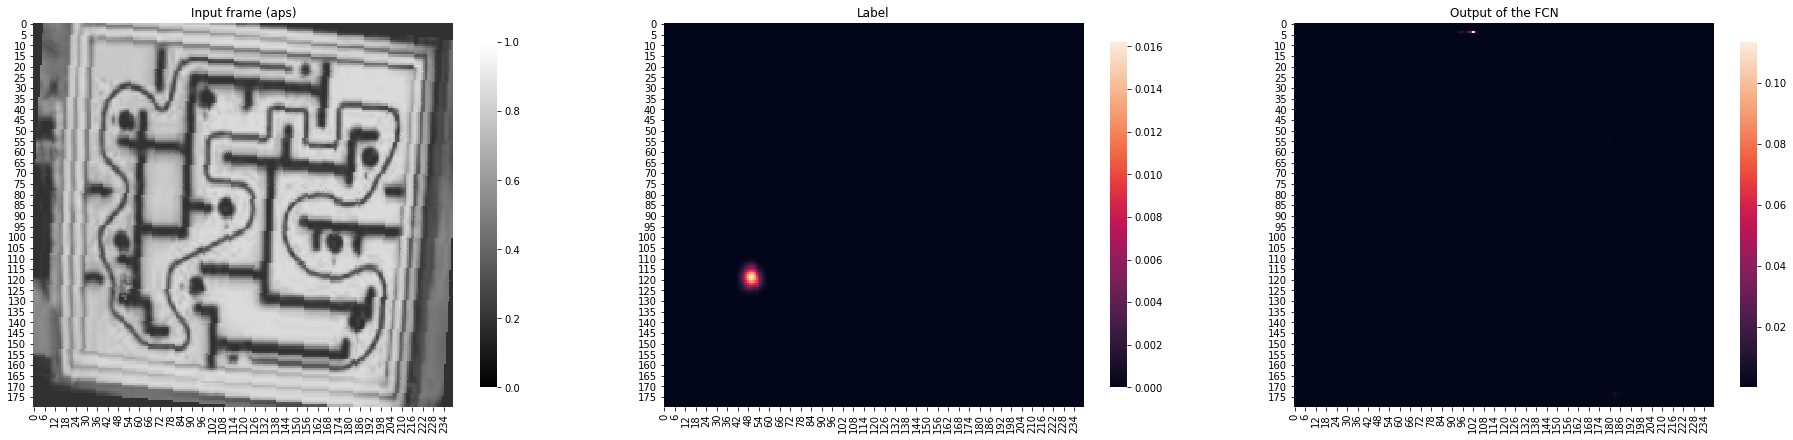

Training Loss: 62.9801


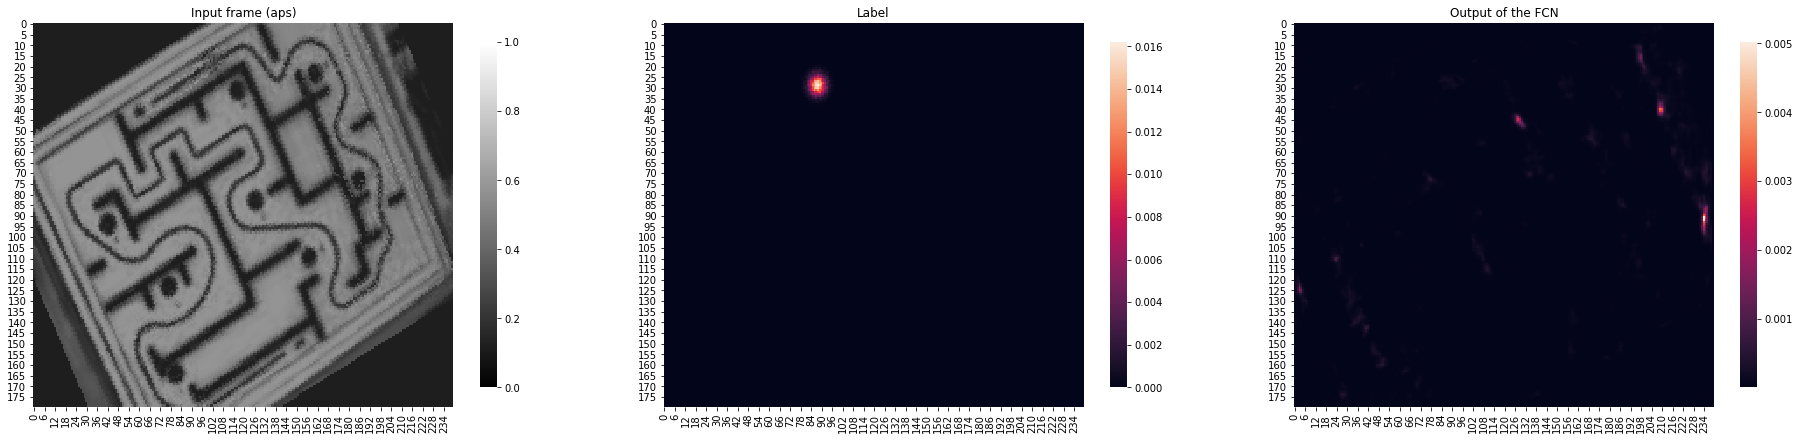

Training Loss: 78.1698


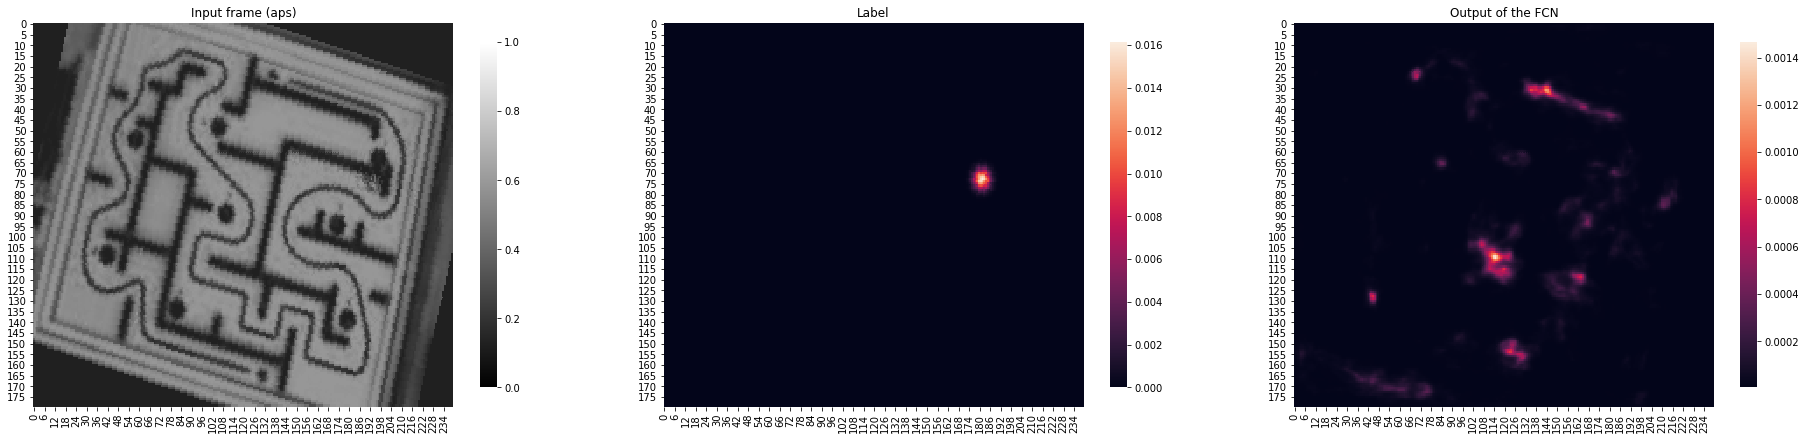

Training Loss: 37.5399


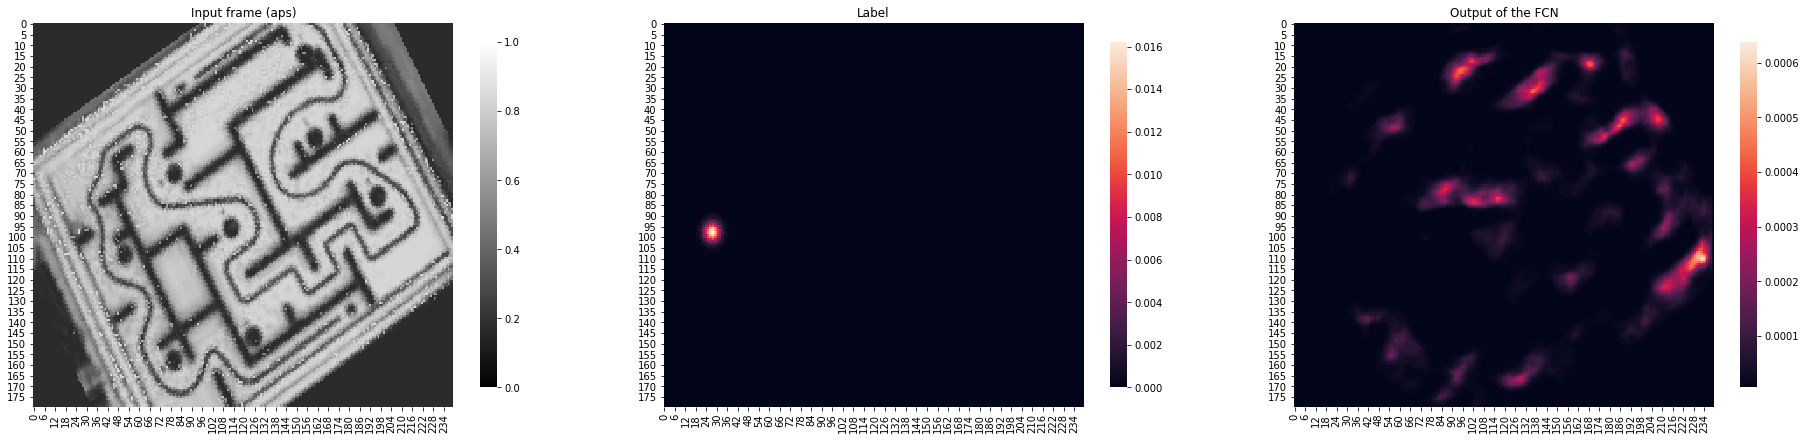

Training Loss: 102.4692


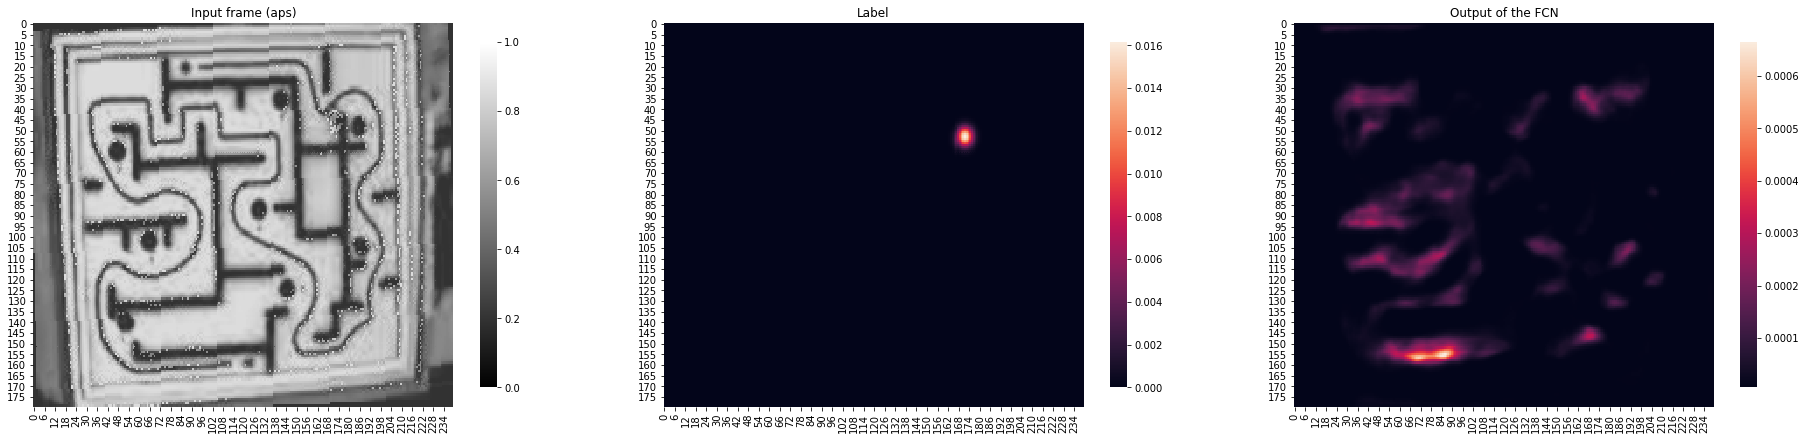

Training Loss: 66.4742


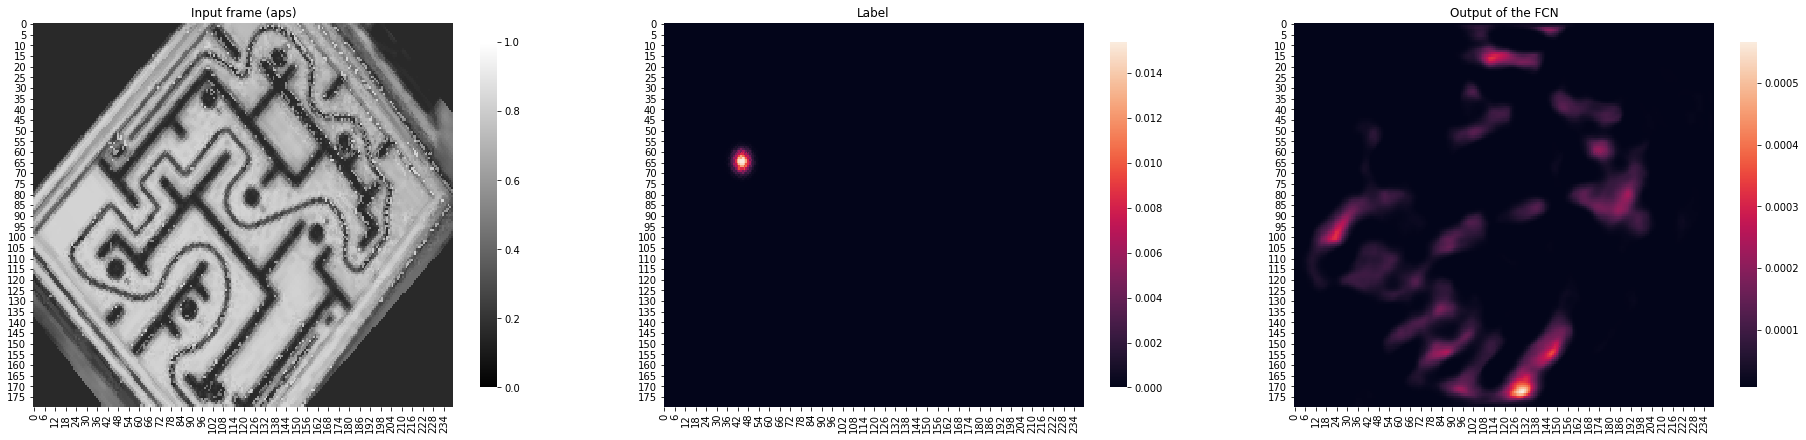

Training Loss: 69.0923


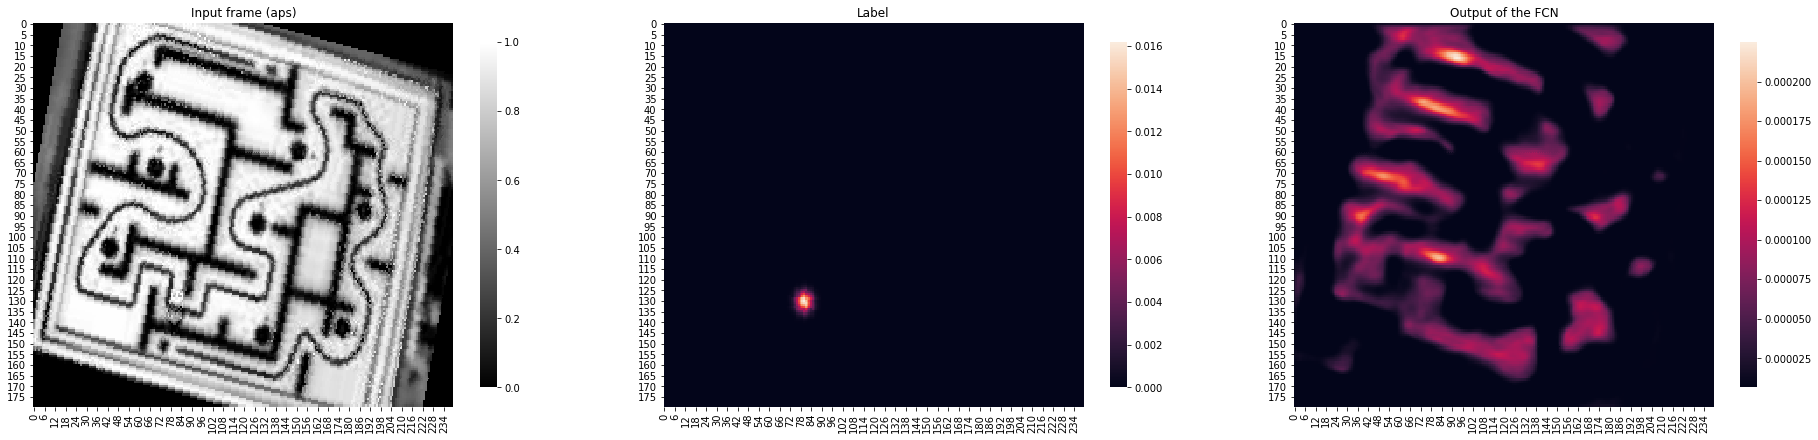

Training Loss: 56.5661


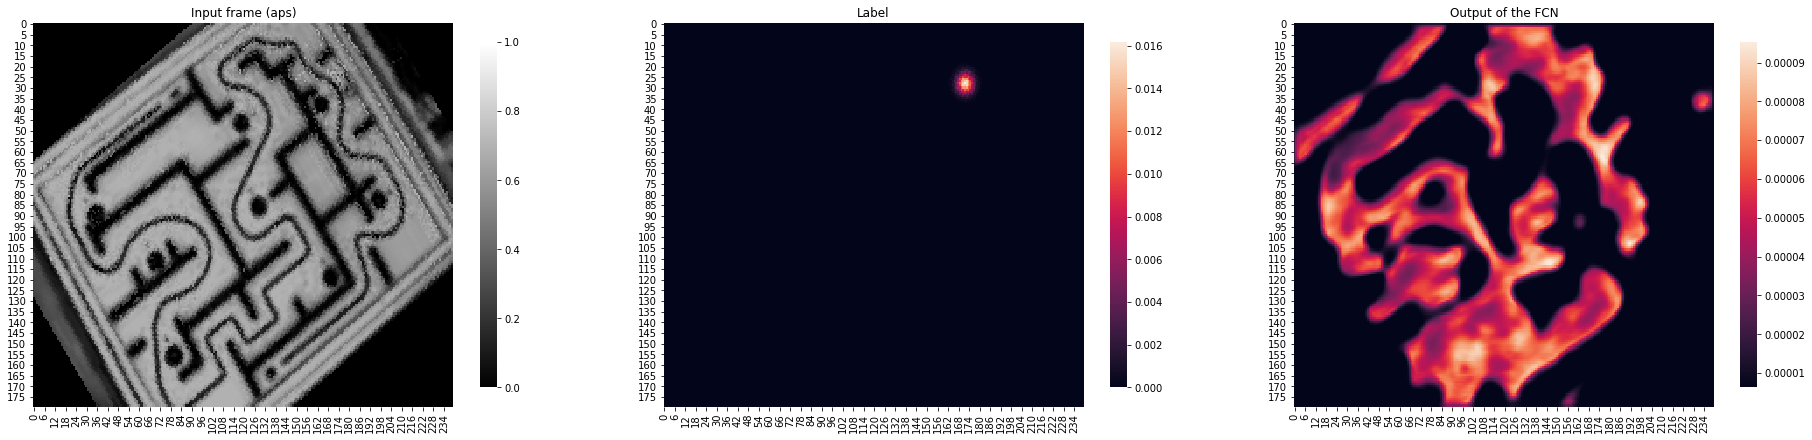

Training Loss: 16.8167


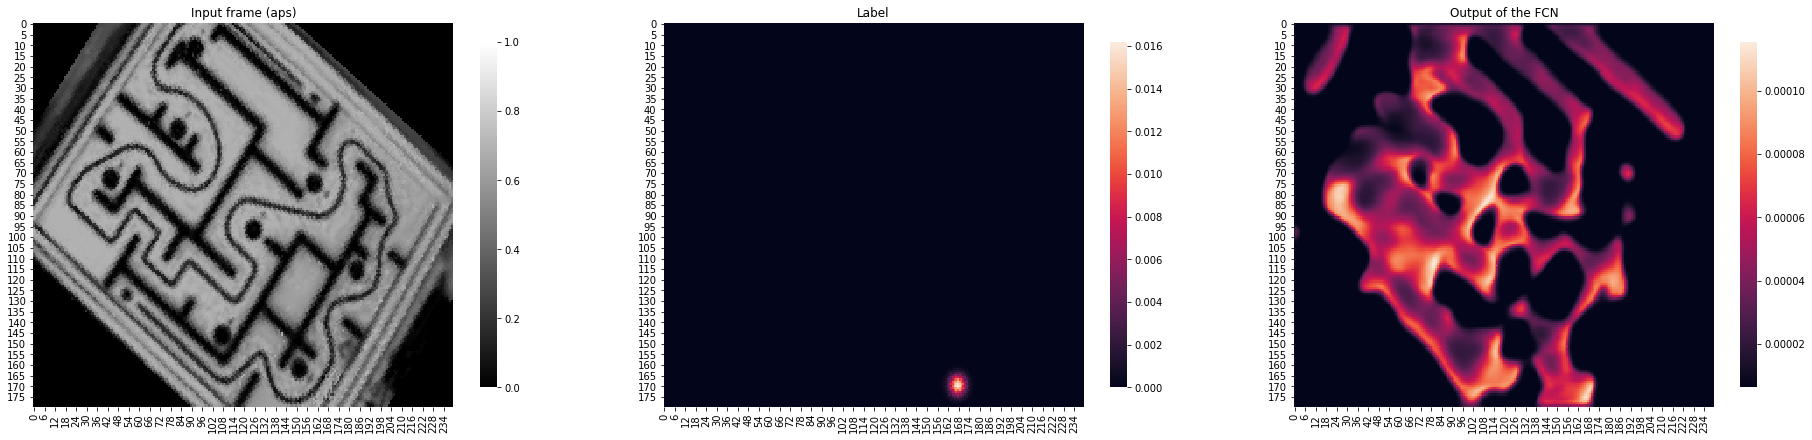

Training Loss: 51.6012


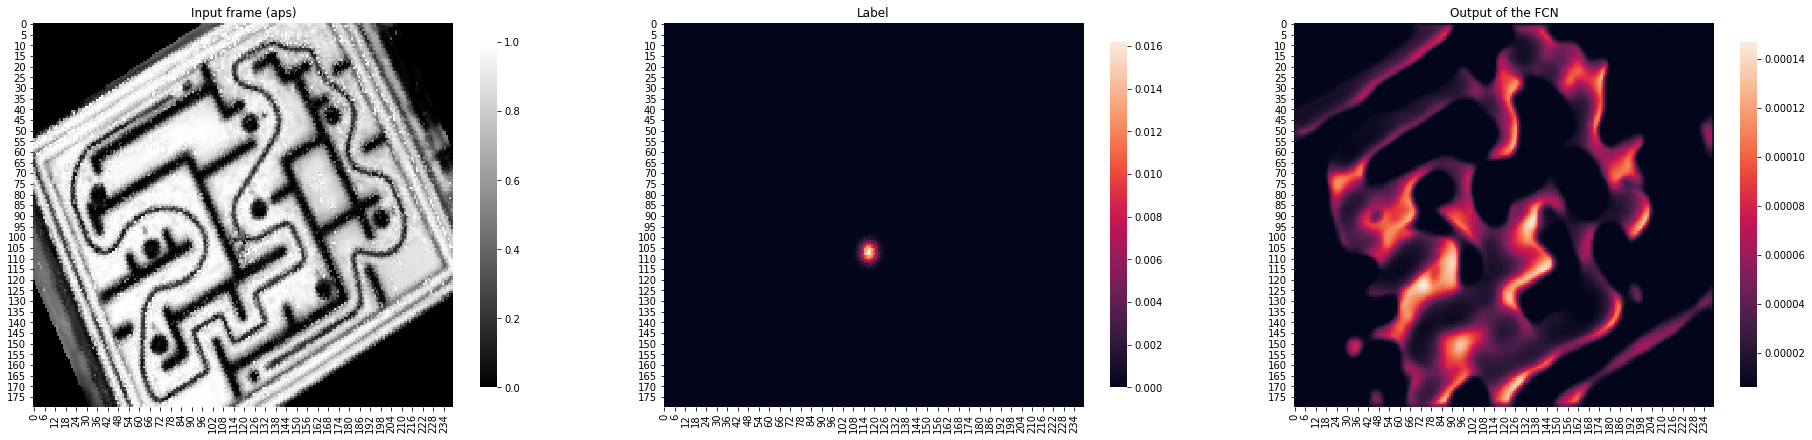

Training Loss: 22.6846


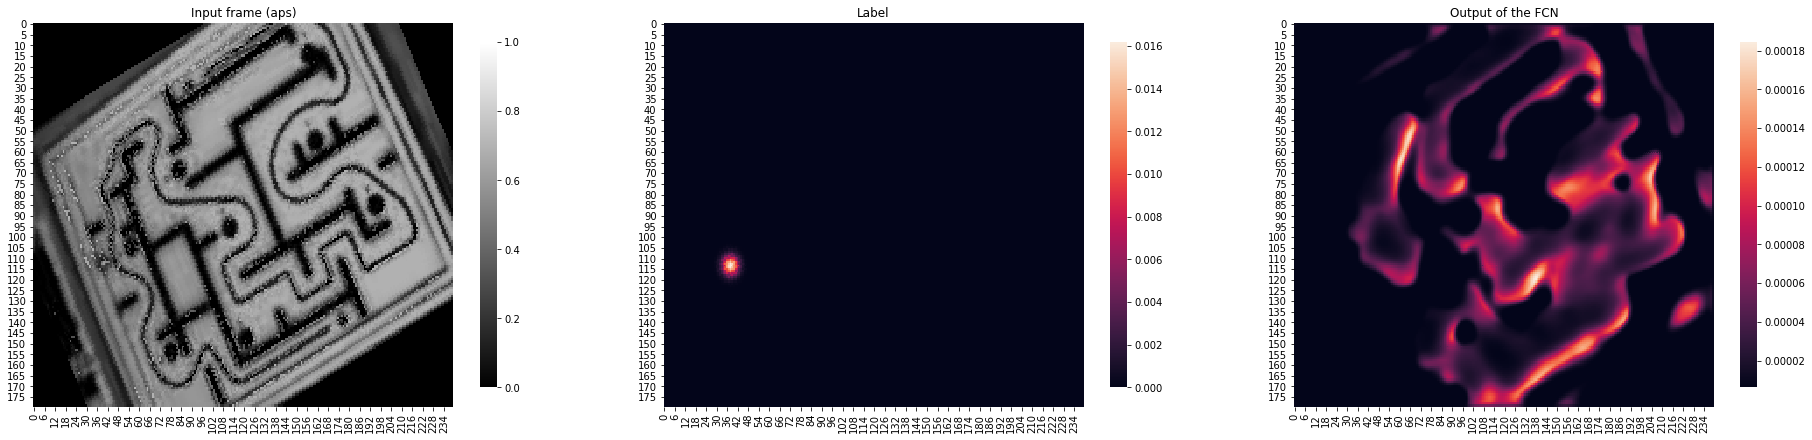

Training Loss: 49.8321


In [ ]:
optimizer = optim.Adam(net.parameters(), lr=0.001)

epochs = 1
epochs_no_improve_limit = 7
plot_heatmaps = True


train_losses = []
val_losses = []
def train():
    epochs_no_improve = 0
    min_val_loss = np.Inf
    since = time.time()
    iteration = 0
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch + 1, epochs))
        print('-' * 10)
        val_loss = 0
        train_loss = 0
        num = 10
        
        for train_inputs, train_labels in dataloaders['train']:            
                optimizer.zero_grad()
                output = net(torch.from_numpy(np.array(train_inputs)).to(device))
                train_labels = np.divide(train_labels, np.sum(np.array(train_labels)))
                loss = loss_fn(output[0].cpu(), torch.from_numpy(np.array(train_labels)[0][0]).cpu())*(distance(output[0].cpu().detach().numpy(), np.array(train_labels)[0][0])/4)
                train_loss += loss

                if plot_heatmaps:
                    fig = plt.figure(figsize = (32,24))
                    ax1 = fig.add_subplot(3, 3, 1)
                    ax1.set_title('Input frame (aps)')
                    ax2 = fig.add_subplot(3, 3, 2)
                    ax2.set_title('Label')
                    ax3 = fig.add_subplot(3, 3, 3)
                    ax3.set_title('Output of the FCN')
                    sns.heatmap(train_inputs[0][0], vmin=0, vmax=1, cmap='gray', ax=ax1, cbar_kws={'shrink': .9})
                    sns.heatmap(train_labels[0][0], ax=ax2, cbar_kws={'shrink': .9})
                    sns.heatmap(output[0].cpu().detach().numpy(), ax=ax3, cbar_kws={'shrink': .9})
                    plt.show()

                print('Training Loss: {:.4f}'.format(loss.item()))
                loss.backward()
                optimizer.step()
                train_losses.append(float(loss))
                iteration += 1
        
#         with torch.no_grad():
#             for val_inputs, val_labels in dataloaders['val']:
                
#                 output = net(torch.from_numpy(np.array(val_inputs)).to(device))
#                 loss = loss_fn(output[0].cpu(), torch.from_numpy(np.array(val_labels)[0][0]).cpu())*(distance(output[0].cpu().detach().numpy(), np.array(val_labels)[0][0])/4)
#                 val_loss += loss

#             val_loss = val_loss / len(dataloaders['val'])
#             val_losses.append(float(val_loss))
#             print('-' * 10)
#             print('Validation Loss: {:.4f}'.format(val_loss))

#             if val_loss < min_val_loss:
#                 torch.save({'state_dict': net.state_dict()}, 'Nets/pt-labi_CNN.pt')
#                 epochs_no_improve = 0
#                 min_val_loss = val_loss
#             else:
#                 epochs_no_improve += 1
#                 if epochs_no_improve == epochs_no_improve_limit:
#                     print('Early stopping initiated')
#                     model = torch.load('Nets/pt-labi_CNN.pt')
#                     print('Best model so far has been loaded')

#     print('Least validation Loss: {:4f}'.format(min_val_loss))
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Finished training')
train()

In [ ]:
print(train_losses)
print(val_losses)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training- vs. Validation-Loss')
plt.ylabel('Modified LAD-Loss')
plt.xlabel('Iterations')
plt.show()

In [ ]:
fig = plt.figure(figsize=(8, 5))
line_weight = 3
alpha = .8
ax1 = fig.add_axes([0, 0, 1, 1])
ax2 = fig.add_axes()
ax2 = ax1.twiny()
lns1 = ax1.plot(train_losses, color='blue', lw=line_weight, alpha=alpha, label='Training Losses')
lns2 = ax2.plot(val_losses, color='orange', lw=line_weight, alpha=alpha, label='Validation Losses')
leg = lns1 + lns2
labs = [l.get_label() for l in leg]
ax1.legend(leg, labs, loc='upper right')
plt.title('Training- vs. Validation-Loss', fontsize=15)
plt.ylabel('Modified LAD-Loss')
plt.xlabel('Epochs')
plt.show()

In [ ]:
plot_heatmaps = True
write_output = True
def test():
    test_loss = 0
    iteration = 0
    num_test_samples = 30
    with torch.no_grad():
        for idx, (test_inputs, test_labels) in enumerate(dataloaders['test']):
            if idx >= num_test_samples:
                break
            else:
                output = net(torch.from_numpy(np.array(test_inputs)).to(device))
                test_labels = np.divide(test_labels, np.sum(np.array(test_labels)))
                loss = loss_fn(output[0].cpu(), torch.from_numpy(np.array(test_labels)[0][0]).cpu())*(distance(output[0].cpu().detach().numpy(), np.array(test_labels)[0][0])/4)
                test_loss += loss
                if write_output:
                    FileName = f'Data/OutputMovie/output-%04d.png' % iteration
                    cv2.imwrite(FileName, np.float32(output.cpu()[0]) * 20000)
                if plot_heatmaps:
                    fig = plt.figure(figsize = (32,24))
                    ax1 = fig.add_subplot(2, 2, 1)
                    ax1.set_title('Output')
                    ax2 = fig.add_subplot(2, 2, 2)
                    ax2.set_title('Label')
                    sns.heatmap(output[0].cpu().detach().numpy(),ax=ax1, square=True, cbar_kws={'shrink': .8})
                    sns.heatmap(test_labels[0][0], ax=ax2, square=True, cbar_kws={'shrink': .8})
                    plt.show()
                iteration += 1
        
        test_loss = test_loss/num_test_samples
        print('Average test loss: ' ,test_loss.numpy())
        print('Testing completed')
test()